In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

from tqdm.notebook import trange, tqdm

from seqeval.metrics import accuracy_score, f1_score, classification_report

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForTokenClassification, BertTokenizer, BertConfig
from transformers import DistilBertForTokenClassification, DistilBertTokenizer, DistilBertConfig
from transformers import RobertaForTokenClassification, RobertaTokenizer, RobertaConfig

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.59
transformers version : 2.2.0


# Data

### To pandas

In [3]:
#export
def readdf(filename, split=' '):
    ''' read file to dataframe '''
    f = open(filename)
    data, sentence, label = [], [], []
    sentence_idx = 0
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n" or line == '\t\n':
            if len(sentence) > 0:
                for word, tag in zip(sentence, label):
                    data.append( (word, tag, sentence_idx) )
                sentence_idx += 1
                sentence, label = [], []
            continue
        splits = line.split(split)
        sentence.append(splits[0])
        label.append(splits[-1][:-1])

    if len(sentence) > 0:
        for word, tag in zip(sentence, label):
            if tag != '\ufeff': # 'datasets/WNUT17/emerging.dev.conll' ends w/ this
                data.append( (word, tag, sentence_idx) )
    return pd.DataFrame(data, columns=['word', 'tag', 'sentence_idx'])

In [4]:
df = readdf('datasets/WNUT17/emerging.dev.conll', split='\t')
print('valid sentences:', df['sentence_idx'].max()+1)
df = readdf('datasets/WNUT17/emerging.test.annotated', split='\t')
print('test sentences:', df['sentence_idx'].max()+1)
df = readdf('datasets/WNUT17/wnut17train.conll', split='\t')
print('train sentences:', df['sentence_idx'].max()+1)
df['tag'].unique()

valid sentences: 1009
test sentences: 1287
train sentences: 3394


array(['O', 'B-location', 'I-location', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product',
       'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product'], dtype=object)

In [5]:
#export
def readdfsentences(filename, split=' '):
    df = readdf(filename, split)
    
    agg_func = lambda s: ' '.join(s["word"].values)
    sentences = df.groupby("sentence_idx").apply(agg_func)
    agg_func = lambda s: ' '.join(s["tag"].values)
    labels = df.groupby("sentence_idx").apply(agg_func)
    
    df = pd.concat([sentences, labels], axis=1)
    df.columns = ['sentences', 'labels']
    return df

In [7]:
d = readdfsentences('datasets/WNUT17/wnut17train.conll', split='\t')
d.head()

,sentences,labels
sentence_idx,,
0,@paulwalk It 's the view from where I 'm livin...,O O O O O O O O O O O O O O B-location I-locat...
1,From Green Newsfeed : AHFA extends deadline fo...,O O O O B-group O O O O O O O O O O
2,Pxleyes Top 50 Photography Contest Pictures of...,B-corporation O O O O O O O O O O O
3,today is my last day at the office .,O O O O O O O O O
4,"4Dbling 's place til monday , party party part...",B-person O O O O O O O O O O O


In [8]:
DATA_ROOT = 'datasets/WNUT17/'
train_df = readdfsentences(DATA_ROOT + 'wnut17train.conll', split='\t')
valid_df = readdfsentences(DATA_ROOT + 'emerging.dev.conll', split='\t')
test_df = readdfsentences(DATA_ROOT + 'emerging.test.annotated', split='\t')
print(train_df.shape, valid_df.shape, test_df.shape)
test_df.head()

(3394, 2) (1009, 2) (1287, 2)


,sentences,labels
sentence_idx,,
0,& gt ; * The soldier was killed when another a...,O O O O O O O O O O O O O O O O O O O O B-loca...
1,& gt ; * Police last week evacuated 80 village...,O O O O O O O O O O O B-location I-location O ...
2,& gt ; * The army on Thursday recovered the bo...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,& gt ; * The four civilians killed included tw...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,The bodies of the soldiers were recovered afte...,O O O O O O O O O O O O O B-group I-group I-gr...


In [9]:
# join train and valid dfsb
train_df['valid'] = False
valid_df['valid'] = True
train_df = pd.concat([train_df, valid_df])
train_df.head()

,sentences,labels,valid
sentence_idx,,,
0,@paulwalk It 's the view from where I 'm livin...,O O O O O O O O O O O O O O B-location I-locat...,False
1,From Green Newsfeed : AHFA extends deadline fo...,O O O O B-group O O O O O O O O O O,False
2,Pxleyes Top 50 Photography Contest Pictures of...,B-corporation O O O O O O O O O O O,False
3,today is my last day at the office .,O O O O O O O O O,False
4,"4Dbling 's place til monday , party party part...",B-person O O O O O O O O O O O,False


### Config

In [10]:
MODEL_CLASSES = {
    'roberta': (RobertaForTokenClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForTokenClassification, DistilBertTokenizer, DistilBertConfig),
    'bert': (BertForTokenClassification, BertTokenizer, BertConfig)
}

In [11]:
# Parameters
seed = 42
use_fp16 = True
bs = 16

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['distilbert-base-uncased', 'distilbert-base-uncased-distilled-squad'])

In [14]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [15]:
seed_all(seed)

### Tokenizer

In [16]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [17]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [18]:
tokenizer_class.pretrained_vocab_files_map

{'vocab_file': {'distilbert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt',
  'distilbert-base-uncased-distilled-squad': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt'}}

### Vocab

In [19]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [20]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

### Label config

In [21]:
PAD_label = '<x>'
BOS_label = '<s>'
EOS_label = '</s>'

labels = ['O', 'B-location', 'I-location', '', 'B-group', 'B-corporation', 'B-person', 'B-creative-work', 'B-product',
           'I-person', 'I-creative-work', 'I-corporation', 'I-group', 'I-product', BOS_label, EOS_label, PAD_label]

### Fix labels (to work for byte encoding)

In [22]:
tokenize_processor.process_one('Goodmorning')

['[CLS]', 'good', '##mo', '##rn', '##ing', '[SEP]']

In [23]:
def pad_labels(df, PAD='<x>', test_length=False, split=' '):

    new_labels = []
    for str_sentence, labels in tqdm(zip(df['sentences'], df['labels']), total=len(df['labels'])):
        str_labels = labels
        labels = labels.split(' ')
        sentence = str_sentence.split(' ')
        assert len(sentence) == len(labels)

        padded_labels = []
        for word, label in zip(sentence, labels):
            tokens = tokenize_processor.process_one(word)
            tokens = tokens[1:-1] # remove <s> and </s>

            padded_labels.extend( [label] + [PAD] * int(len(tokens)-1) )

        new_sentence_labels = ' '.join(padded_labels)
        new_labels.append(new_sentence_labels)

        if test_length:
            tokens = tokenize_processor.process_one(str_sentence)
            if len(tokens)-2 != len(new_sentence_labels.split(' ')):
                print(str_sentence)
                print()
                print(str_labels)
                return None

    if not test_length:
        df['labels'] = new_labels

In [24]:
# test
# pad_labels(train_df, PAD_label, test_length=True)
# pad_labels(test_df, PAD_label, test_length=True)

In [25]:
pad_labels(train_df, PAD_label)
pad_labels(test_df, PAD_label)

In [26]:
test_df.head()

,sentences,labels
sentence_idx,,
0,& gt ; * The soldier was killed when another a...,O O O O O O O O O O O O O O O O O O O O B-loca...
1,& gt ; * Police last week evacuated 80 village...,O O O O O O O O O O O B-location <x> <x> I-loc...
2,& gt ; * The army on Thursday recovered the bo...,O O O O O O O O O O O O O O O O O O O O O O O ...
3,& gt ; * The four civilians killed included tw...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,The bodies of the soldiers were recovered afte...,O O O O O O O O O O <x> O O O B-group I-group ...


### Labels

In [27]:
class LabelTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, max_seq_len=999, **kwargs):
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        return [BOS_label] + t.split(' ') + [EOS_label]

In [28]:
label_tokenizer = Tokenizer(tok_func = LabelTokenizer(), pre_rules=[], post_rules=[])

In [29]:
class LabelVocab(Vocab):
    def __init__(self, labels):
        super().__init__(itos = [])
        self.int2str = labels
        self.str2int = { s:i for i,s in enumerate(labels) }
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return list(map(lambda i: self.str2int[i], t))
    
    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(list(map(lambda i: self.int2str[i], nums)))

In [30]:
def LabelNumericalizeProcessor(ds, **kwargs):
    return NumericalizeProcessor(ds, vocab=LabelVocab(labels))

In [31]:
def LabelTokenizeProcessor(ds, **kwargs):
    return TokenizeProcessor(ds, tokenizer=label_tokenizer, include_bos=False, include_eos=False)

In [32]:
class TextLabelList(TextList):
    _processor = [LabelTokenizeProcessor, LabelNumericalizeProcessor]

### Databunch

In [33]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [34]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].y, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [35]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextLabelList

In [36]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [37]:
data = (Seq2SeqTextList.from_df(train_df, cols='sentences', processor=transformer_processor)
       .split_from_df(col='valid')
       .label_from_df(cols='labels', label_cls=TextLabelList)
       .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [38]:
# NOTE: this is more of a hack for getting metrics on test dataset
# usage: validate_learner(learner, test_dl, metrics=[f1, acc])
# returns 
temp = test_df[:31].copy()
temp['test'] = False
test_df['test'] = True

test_df_fastai = pd.concat([test_df, temp])

# Note: test data is saved in 'data_test' as valid data (this can be confusing)
data_test = (Seq2SeqTextList.from_df(test_df_fastai, cols='sentences', processor=transformer_processor)
           .split_from_df(col='test')
           .label_from_df(cols='labels', label_cls=TextLabelList)
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

# use only this var: (ex below)
test_dl = data_test.valid_dl 
# validate_learner(learner, test_dl, metrics=[f1, acc])

def validate_learner(learner, dataloader, metrics):
    class Temp:
        def update_graph(*args):
            pass
    
    learner.losses = [0]
    learner.nb_batches = [0]
    learner.val_losses = [0]
    learner.pbar = Temp()
    out = learner.validate(dataloader, callbacks=[], metrics=metrics)
    return out[1:]

In [39]:
i = 2
print((len(data.train_ds[i][0].data), len(data.train_ds[i][1].data)))
data.train_ds[i][0].text, data.train_ds[i][1].text

(32, 32)


('[CLS] p ##xley ##es top 50 photography contest pictures of august 2010 . . . http : / / bit . l ##y / b ##gc ##y ##z ##0 # photography [SEP]',
 '<s> B-corporation <x> <x> O O O O O O O O O <x> <x> O <x> <x> <x> <x> <x> <x> <x> <x> <x> <x> <x> <x> <x> O <x> </s>')

In [40]:
print((data.train_ds[i][0].data, data.train_ds[i][1].data))

(array([  101,  1052, 20959,  2229,  2327,  2753,  5855,  5049,  4620,  1997,  2257,  2230,  1012,  1012,  1012,  8299,
        1024,  1013,  1013,  2978,  1012,  1048,  2100,  1013,  1038, 18195,  2100,  2480,  2692,  1001,  5855,   102]), array([14,  5, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 16,  0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16,  0, 16, 15]))


In [41]:
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

In [42]:
# a = test_one_batch
# a[1]

### Model & Learner

In [43]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        # input_ids: [b,s] s - words in sentence
        
#         attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        out = self.transformer(input_ids, attention_mask = attention_mask)
        logits = out[0] # [b,s,C]
        return logits

In [44]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(labels) # <s>, </s>, <x>
config.use_bfloat16 = use_fp16
print(config)

{
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "is_decoder": false,
  "max_position_embeddings": 512,
  "n_heads": 12,
  "n_layers": 6,
  "num_labels": 17,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torchscript": false,
  "use_bfloat16": true,
  "vocab_size": 30522
}



In [45]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [46]:
Loss = CrossEntropyFlat()

In [47]:
pad_nr = labels.index(PAD_label)
bos_nr = labels.index(BOS_label)
eos_nr = labels.index(EOS_label)

def f1(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
    y_true = list(map(lambda x: labels[x], y_true[mask]))
    y_pred = list(map(lambda x: labels[x], y_pred[mask]))
    return torch.tensor(f1_score(y_true, y_pred))

def acc(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
    return accuracy_score(y_true[mask], y_pred[mask])

In [48]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(data, custom_transformer_model, loss_func=Loss,
                  opt_func = lambda input_: AdamW(input_, correct_bias=False), 
                  metrics=[f1, acc])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [49]:
# print(learner.model)

In [50]:
if model_type == 'roberta': # For roberta-base
    list_layers = [learner.model.transformer.roberta.embeddings,
                  learner.model.transformer.roberta.encoder.layer[0],
                  learner.model.transformer.roberta.encoder.layer[1],
                  learner.model.transformer.roberta.encoder.layer[2],
                  learner.model.transformer.roberta.encoder.layer[3],
                  learner.model.transformer.roberta.encoder.layer[4],
                  learner.model.transformer.roberta.encoder.layer[5],
                  learner.model.transformer.roberta.encoder.layer[6],
                  learner.model.transformer.roberta.encoder.layer[7],
                  learner.model.transformer.roberta.encoder.layer[8],
                  learner.model.transformer.roberta.encoder.layer[9],
                  learner.model.transformer.roberta.encoder.layer[10],
                  learner.model.transformer.roberta.encoder.layer[11],
                  learner.model.transformer.roberta.pooler,
                  learner.model.transformer.classifier]
    
elif model_type == 'bert':
    list_layers = [learner.model.transformer.bert.embeddings,
                  learner.model.transformer.bert.encoder.layer[0],
                  learner.model.transformer.bert.encoder.layer[1],
                  learner.model.transformer.bert.encoder.layer[2],
                  learner.model.transformer.bert.encoder.layer[3],
                  learner.model.transformer.bert.encoder.layer[4],
                  learner.model.transformer.bert.encoder.layer[5],
                  learner.model.transformer.bert.encoder.layer[6],
                  learner.model.transformer.bert.encoder.layer[7],
                  learner.model.transformer.bert.encoder.layer[8],
                  learner.model.transformer.bert.encoder.layer[9],
                  learner.model.transformer.bert.encoder.layer[10],
                  learner.model.transformer.bert.encoder.layer[11],
                  learner.model.transformer.bert.pooler,
                  learner.model.transformer.classifier]

elif model_type == 'distilbert':
    list_layers = [learner.model.transformer.distilbert.embeddings,
                   learner.model.transformer.distilbert.transformer.layer[0],
                   learner.model.transformer.distilbert.transformer.layer[1],
                   learner.model.transformer.distilbert.transformer.layer[2],
                   learner.model.transformer.distilbert.transformer.layer[3],
                   learner.model.transformer.distilbert.transformer.layer[4],
                   learner.model.transformer.distilbert.transformer.layer[5],
                   learner.model.transformer.classifier]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learner.layer_groups)

Learner split in 8 groups


### Training

#### -1 layers

In [51]:
learner.freeze_to(-1)
# learner.summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.74E-02


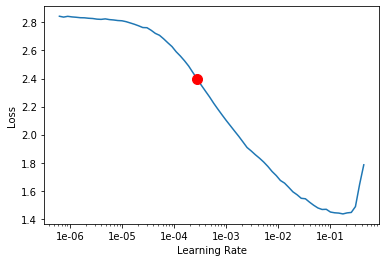

In [52]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,f1,acc,time
0,0.329086,0.531325,0.062327,0.000000,00:14


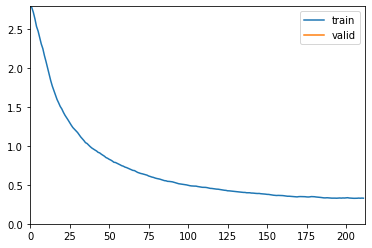

In [53]:
lr = 1e-3
learner.fit_one_cycle(1, max_lr=lr, moms=(0.8, 0.9))

#### -2 layers

In [109]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-05


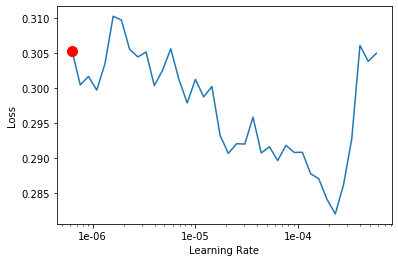

In [110]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,f1,acc,time
0,0.131363,0.490166,0.265344,0.000000,00:29


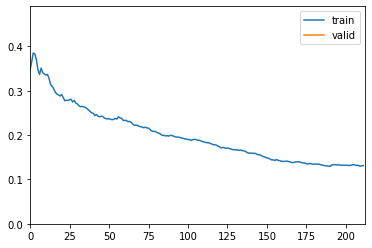

In [111]:
lr = 1e-4
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

#### -4 layers

In [112]:
learner.freeze_to(-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


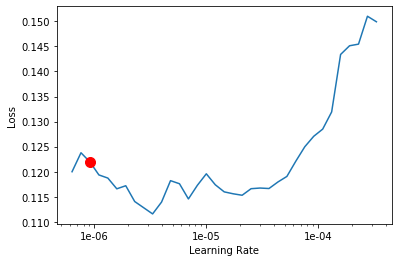

In [113]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,f1,acc,time
0,0.095191,0.518740,0.312904,0.000000,01:00


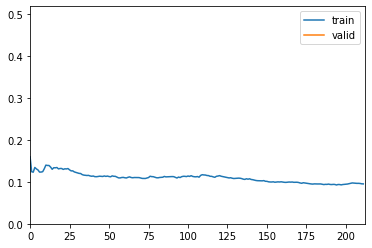

In [114]:
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

#### all layers

In [115]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.31E-08


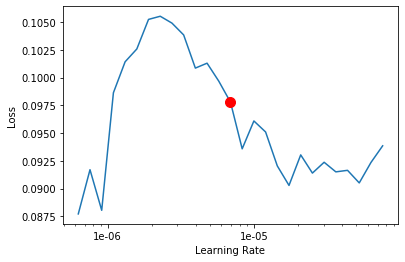

In [116]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,f1,acc,time
0,0.080975,0.533052,0.322207,0.000000,02:30
1,0.065290,0.552657,0.347267,0.000000,02:29
2,0.047959,0.525552,0.370778,0.000000,02:29
3,0.039639,0.557803,0.386092,0.000991,02:29
4,0.032083,0.595216,0.381231,0.000991,02:30
5,0.027977,0.599682,0.376964,0.000991,02:30


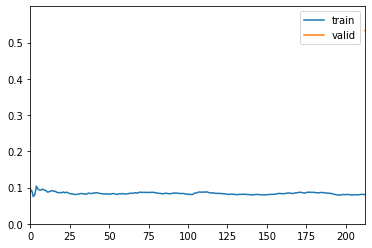

In [117]:
lr = 1e-5
learner.fit_one_cycle(6, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

### Test

In [118]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

def save_lists(y_pred, y_true):
    global y_true_all, y_pred_all
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    mask = (y_true != pad_nr) * (y_true != bos_nr) * (y_true != eos_nr)
    y_true = list(map(lambda x: labels[x], y_true[mask]))
    y_pred = list(map(lambda x: labels[x], y_pred[mask]))
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)
    return torch.tensor(1)

In [119]:
global y_true_all, y_pred_all
y_true_all, y_pred_all = [], []

_ = validate_learner(learner, test_dl, metrics=[save_lists])

In [120]:
f1_score(y_true_all, y_pred_all)*100, accuracy_score(y_true_all, y_pred_all)*100

(17.970149253731343, 86.21288692356286)

In [121]:
print(classification_report(y_true_all, y_pred_all))

             precision    recall  f1-score   support

     person       0.79      0.45      0.58       429
   location       0.53      0.39      0.45       150
    product       0.13      0.03      0.05       127
       work       0.33      0.11      0.16       142
      group       0.34      0.12      0.18       165
corporation       0.16      0.14      0.15        66

  micro avg       0.13      0.28      0.18      1079
  macro avg       0.51      0.28      0.35      1079

